<a href="https://colab.research.google.com/github/spatialtopology/spacetop-prep/blob/master/spacetop-prep/physio/spacetop_biopac_analysis_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

# Physio analysis with Neurokit: Pipeline for spacetop data

### To navigate, simply click on a cell and hit Shift + Enter.

**The purpose of this notebook is to demonstrate:**
1.   How to load in biopac acquisition files into a python environment
2.   Which set of neurokit functions to use
3.   A demonstration of an analysis (the effect of stimulus intensity on skin conductance response)



In [1]:
__author__ = "Heejung Jung, Isabel Neumann"
__copyright__ = "Spatial Topology Project"
__credits__ = ["Yarik"] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung.gr@dartmouth.edu"
__status__ = "Development"

If you encounter bugs, have any questions, or comments, please raise an issue in our GitHub repository: https://github.com/jungheejung/spacetop_biopac

### Import packages 


In [ ]:
!pip install neurokit2
!pip install bioread

In [3]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, sys
from pathlib import Path
from os.path import join
import itertools
from statistics import mean

plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

In [4]:
!git clone https://github.com/spatialtopology/spacetop-prep.git
# 

Cloning into 'spacetop-prep'...
remote: Enumerating objects: 954, done.
remote: Counting objects: 100% (503/503), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 954 (delta 369), reused 465 (delta 336), pack-reused 451
Receiving objects: 100% (954/954), 1.00 MiB | 4.21 MiB/s, done.
Resolving deltas: 100% (586/586), done.


In [5]:
sys.path.insert(0,'/content/spacetop-prep/spacetop-prep/physio')
import utils
from utils import preprocess, initialize

## 1.Download example dataset 
(spacetop cue-expectancy task, sub-0051, ses-03, run-02)

In [ ]:
!gdown 1SMnCANtc3LuocGTFq1d7ZrzlchWb_24v
!unzip /content/example_data.zip

## 2.Load data
Feed in meta data for data files

In [7]:
pwd = os.getcwd()
# sub-0051_ses-03_run-02
main_dir = pwd
sub_num = 51; ses_num = 3; run_num = 2
sub = f"sub-{sub_num:04d}"; 
ses = f"ses-{ses_num:02d}"
run = f"run-{run_num-1:02d}"
physio_fname = join(main_dir, 'data', sub, ses, 'physio', f"SOCIAL_spacetop_{sub}_{ses}_task-social_ANISO.acq")
beh_fname = glob.glob(join(main_dir, 'data', sub, ses, 'beh', f"{sub}_{ses}_task-social_{run}-*_beh.csv"))[0]

In [8]:
print("load physio data...")
physio_df, samplingrate = nk.read_acqknowledge(physio_fname)
print("check physio data columns: ",physio_df.columns)

beh_df = pd.read_csv(beh_fname)

load physio data...
check physio data columns:  Index(['Skin Conductance (EDA) - EDA100C-MRI', 'Pulse (PPG) - PPG100C',
       'fMRI Trigger - CBLCFMA - Current Feedba',
       'TSA2 TTL - CBLCFMA - Current Feedback M', 'trigger', 'fixation', 'cue',
       'expect', 'administer', 'actual', 'C15', 'C16'],
      dtype='object')


> *   We're going to harmonize the column names before we do any data analysis
> *   Dictionary structure is {`old column name`: `new column name`, ... }
> *   *Mind you, this was named before the CANlab discussed column names across physio data analysis* 

In [9]:
dict_column = {
    'fMRI Trigger - CBLCFMA - Current Feedba':'trigger_mri',
    'TSA2 TTL - CBLCFMA - Current Feedback M':'trigger_heat',
    'Skin Conductance (EDA) - EDA100C-MRI':'physio_eda',
    'Pulse (PPG) - PPG100C':'physio_ppg',
    'trigger': 'event_experimentduration',
    'fixation': 'event_fixation',
    'cue': 'event_cue',
    'expect': 'event_expectrating',
    'administer': 'event_stimuli',
    'actual': 'event_actualrating',
}
physio_df.rename(columns=dict_column, inplace=True)

In [10]:
physio_df.columns


Index(['physio_eda', 'physio_ppg', 'trigger_mri', 'trigger_heat',
       'event_experimentduration', 'event_fixation', 'event_cue',
       'event_expectrating', 'event_stimuli', 'event_actualrating', 'C15',
       'C16'],
      dtype='object')

## +Note about data structure






> In spacetop, we collected all 6 runs in one acquisition file. In between runs, data collection stopped; we resumed again before MRtrigger. 
> As you can see from the output above, we have a number of channels recorded in this physio file.

**Description of the channels**

**A. Two Physio (analog) channels**
1.   **`physio_eda`** Skin  Conductance (EDA)
2.   **`physio_ppg`** Pulse (PPG)

**B. Digital channels**<br> we toggled the channels whenever  MATlab-stim PC transitioned to a new event. In other words, we have boxcar signals for whenever an event was displayed on screen.

1.   **`event_experimentduration`**: when the experiment started/finished, i.e. one boxcar for duration of experiment
2.   **`event_fixation`**: when the fixation was present on screen
3.   **`event_cue`**: when the cue was present on screen (1s per trial, 2 levels of high vs. low)
4.   **`event_expectrating`**: when the participant saw the "expect" keyword until they rated their expectation ratings for the upcoming stimulus
5.   **`event_stimuli`**: when the participant undergoes the stimulus delivery (5s per trial; 9s for pain run, 5s plateau; 3 levels of high vs. med vs. low stimulus intensity)
6.   **`event_actualrating`**:  when the participant saw the "actual" keyword until they rated their actual ratings for the experienced stimulus

**C. TTL channels**

1.   **`trigger_mri`**: TTl signals from the radio-frequency (RF) pulses, recorded in columns. In this study, we would have a TTL for every .46 sec.
2.   **`trigger_heat`**: Only for pain runs. We recorded the TTL signals for every pain stimulus. 1) initiation of pain stimulus 2) time it reached intended temperature (beginning of plateau), 3) time it terminated intended termperature (end of pleateau), and 4) return to baseline temperatuer of 32 degrees

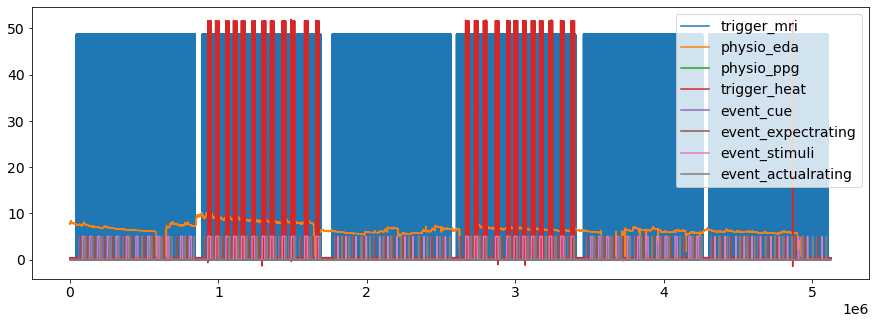

In [ ]:
physio_df[['trigger_mri', 'physio_eda', 'physio_ppg', 'trigger_heat',
           'event_cue', 'event_expectrating', 'event_stimuli', 'event_actualrating']].plot()

> We'll first check if the dataframes look kosher. <br>
Question: Do we see 6 data chunks?



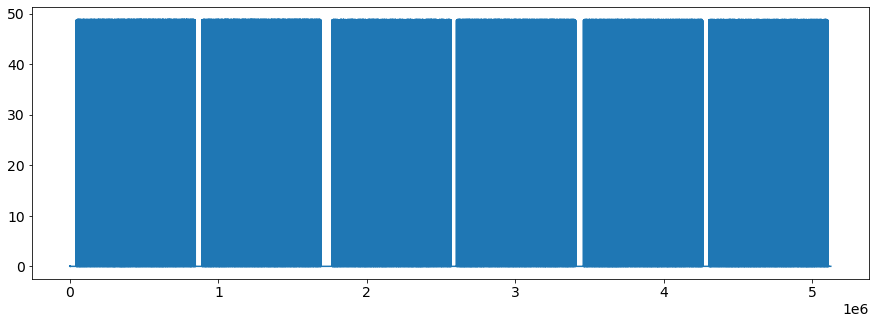

In [11]:
physio_df['trigger_mri'].plot()

> Question: Are the stimulus delivered for all 6 runs? (12 trials per run)

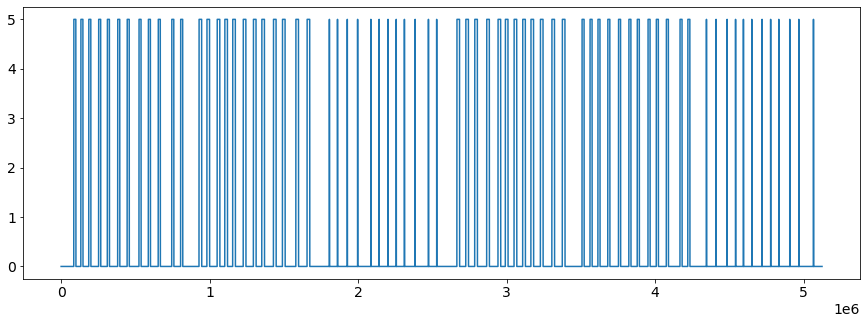

In [12]:
physio_df['event_stimuli'].plot()

> Question: Do we see TSA2 TTLs for the pain runs?

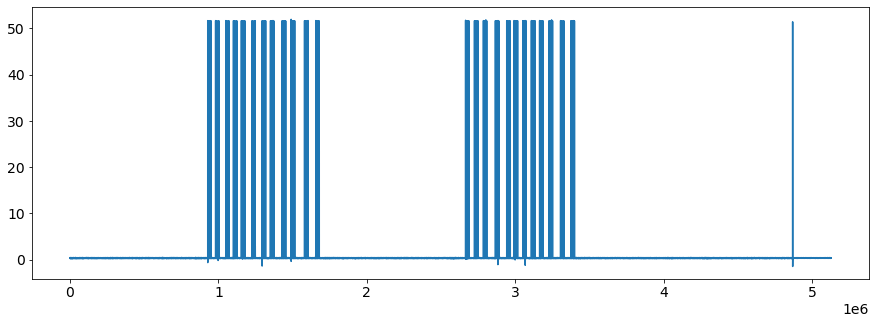

In [13]:
physio_df['trigger_heat'].plot()

## 3.Extract 1 run out of the 6

> Here's a sample code

In [ ]:
# Extract 1 run
mid_val = (np.max(physio_df['event_experimentduration']) - np.min(physio_df['event_experimentduration']))/2
physio_df.loc[physio_df['event_experimentduration'] > mid_val, 'fmri_trigger'] = 5
physio_df.loc[physio_df['event_experimentduration'] <= mid_val, 'fmri_trigger'] = 0

start_df = physio_df[physio_df['fmri_trigger'] > physio_df['fmri_trigger'].shift(1)].index
stop_df = physio_df[physio_df['fmri_trigger'] < physio_df['fmri_trigger'].shift(1)].index
print(f"* indices of each run's start point 'start_df': \n\t{start_df}")
print(f"* indices of each run's end point: 'stop_df': \n\t{stop_df}") 

# Organize data: transition
df_transition = pd.DataFrame({
                        'start_df': start_df, 
                        'stop_df': stop_df
                        })
run_subset = physio_df[df_transition.start_df[run_num-1]: df_transition.stop_df[run_num-1]]
run_df = run_subset.reset_index()


* indices of each run's start point 'start_df': 
	Int64Index([43850, 890568, 1765932, 2603584, 3458812, 4302610], dtype='int64')
* indices of each run's end point: 'stop_df': 
	Int64Index([841528, 1688195, 2563573, 3401638, 4256488, 5100278], dtype='int64')


> We'll use the RF pulse to determine runs. 
* However, there is one caveat: there is always one more TR than programmed (this is the saturation pulse) 
* We need to remove this before using our RF pulses as a basis. 
* First, identify the number of RF pulses -- `dict_spike`
* Then, identify the beginning and end of a run based on RF pulse boxcars -- `dict_runs`
* Lastly, remove one TR from this boxcar. This will be the `dict_runs_adjust`

In [14]:
run_cutoff = 300

In [15]:
# updated code: 

physio_df['mr_aniso'] = physio_df['trigger_mri'].rolling(
window=3).mean()
utils.preprocess._binarize_channel(physio_df,
                                source_col='mr_aniso',
                                new_col='spike',
                                threshold=40,
                                binary_high=5,
                                binary_low=0)
dict_spike = utils.preprocess._identify_boundary(physio_df, 'spike')
physio_df['bin_spike'] = 0
physio_df.loc[dict_spike['start'], 'bin_spike'] = 5

# find transitions of trigger_mri using a rolling window of values slightly smaller than the sampling rate
physio_df['mr_aniso_boxcar'] = physio_df['trigger_mri'].rolling(
    window=int(samplingrate-100)).mean()
mid_val = (np.max(physio_df['mr_aniso_boxcar']) -
        np.min(physio_df['mr_aniso_boxcar'])) / 5
utils.preprocess._binarize_channel(physio_df,
                                source_col='mr_aniso_boxcar',
                                new_col='mr_boxcar',
                                threshold=mid_val,
                                binary_high=5,
                                binary_low=0)
dict_runs = utils.preprocess._identify_boundary(physio_df, 'mr_boxcar')

# remove one TR (this is the siemens TR)
sdf = physio_df.copy()
sdf.loc[dict_runs['start'], 'bin_spike'] = 0
sdf['adjusted_boxcar'] = sdf['bin_spike'].rolling(window=int(samplingrate-100)).mean()
mid_val = (np.max(sdf['adjusted_boxcar']) -
            np.min(sdf['adjusted_boxcar'])) / 4
utils.preprocess._binarize_channel(sdf,
                                    source_col='adjusted_boxcar',
                                    new_col='adjust_run',
                                    threshold=mid_val,
                                    binary_high=5,
                                    binary_low=0)
dict_runs_adjust = utils.preprocess._identify_boundary(sdf, 'adjust_run')

# identify how many runs
run_list = list(range(len(dict_runs_adjust['start'])))

run_bool = ((np.array(dict_runs_adjust['stop'])-np.array(dict_runs_adjust['start']))/samplingrate) > run_cutoff
clean_runlist = list(itertools.compress(run_list, run_bool))
shorter_than_threshold_length = list(itertools.compress(run_list, ~run_bool))

# reference the scannotes


In [58]:
run = 2 # index from 1,2,3,4,56

In [59]:
run_df = physio_df.iloc[dict_runs_adjust['start'][run-1]:dict_runs_adjust['stop'][run-1]]
run_df = run_df.reset_index()

Now plot dataframe to check if we've isolated one run

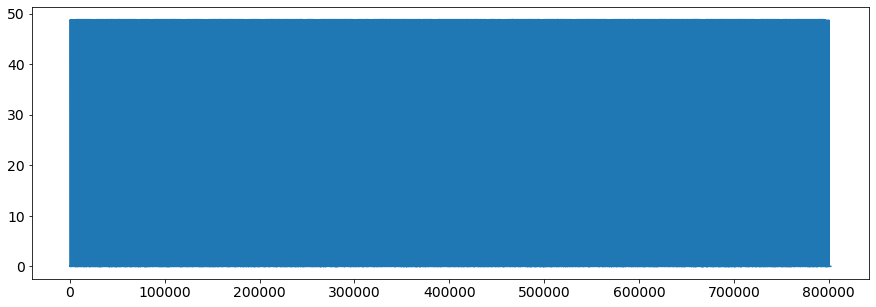

In [60]:
run_df['trigger_mri'].plot()

In [61]:
print(f"Check run length (s): {run_df.shape[0]/samplingrate}")

Check run length (s): 401.148


Check TTL within run


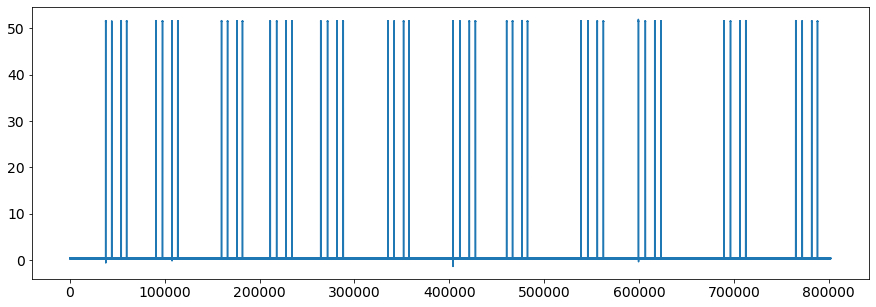

In [62]:
print(f"Check TTL within run")
run_df['trigger_heat'].plot()

## 4.Baseline correction

#### Significance of baseline correction<br>
Baseline correction is important when using interval related analyses. For instance, we might want to compare the average signal difference between a pain run vs. a cognitive run. This is when we would use interval-related analayses. The signals extend for a longer time period, which makes baseline correction imperative. Only after correct baseline correction can we check the overall signal difference. 

#### Methods of baseline correction:
1.   subtract mean baseline, using the 6 TRs
2.   using the fixation period from tthe entire run
3.   using the fixation period from corresponding trial


In this notebook, we'll use method 2, which collapses all of the fixation periods into one bin. We average these signals and subtract it from the main EDA signal. 

In [63]:
fix_bool = run_df['event_fixation'].astype(bool).sum()
print(f"confirming the number of fixation non-szero timepoints: {fix_bool}")
print(f"this amounts to {fix_bool/samplingrate} seconds")

confirming the number of fixation non-szero timepoints: 357248
this amounts to 178.624 seconds


In [64]:
run_df.columns

Index(['index', 'physio_eda', 'physio_ppg', 'trigger_mri', 'trigger_heat',
       'event_experimentduration', 'event_fixation', 'event_cue',
       'event_expectrating', 'event_stimuli', 'event_actualrating', 'C15',
       'C16', 'mr_aniso', 'spike', 'bin_spike', 'mr_aniso_boxcar',
       'mr_boxcar'],
      dtype='object')

baseline using the 6 TR: 9.626150346314006
baseline using fixation from entire run: 8.379528779141685


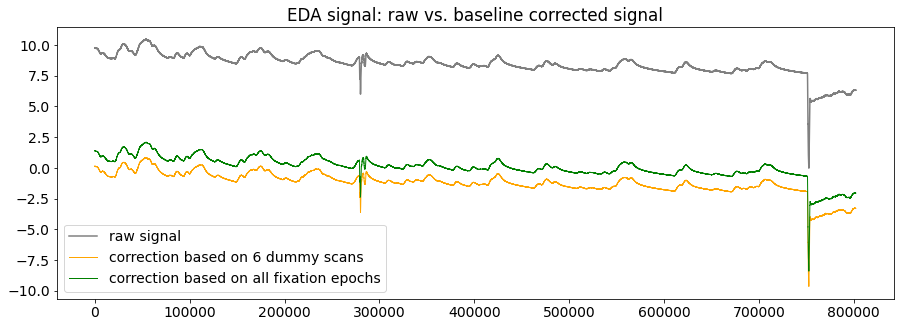

In [71]:
# baseline correction method 1: use the first 6 dummy scan period

baseline_method01 = run_df['physio_eda'].loc[0:5520].mean()
run_df['EDA_corrected_01tr'] = run_df['physio_eda'] - baseline_method01

# baseline correction method 02: use the fixation period from the entire run
mask = run_df['event_fixation'].astype(bool)
baseline_method02 = run_df['physio_eda'].loc[mask].mean()
run_df['EDA_corrected_02fixation'] = run_df['physio_eda'] - baseline_method02

# TODO method 03: per trial, grab the baseline fixation average signal

print(f"baseline using the 6 TR: {baseline_method01}")
print(f"baseline using fixation from entire run: {baseline_method02}")
figure, ax1 = plt.subplots()
ax1.title.set_text('EDA signal: raw vs. baseline corrected signal')
l1 = ax1.plot(run_df['physio_eda'], linewidth=1.5, zorder=1, label="raw signal", color="gray")
l2 = ax1.plot(run_df['EDA_corrected_01tr'], linewidth=1, zorder=1, label="correction based on 6 dummy scans", color="orange")
l3 = ax1.plot(run_df['EDA_corrected_02fixation'], linewidth=1, zorder=1, label="correction based on all fixation epochs", color="green")
ax1.legend(handles=[l1[0], l2[0], l3[0]])
# TODO: add legend, which color is which?

## 5.Neurokit event extraction

> Here's some example code on how we extract events based on the **cue** channel. 
* The idea is that we (1) binarize the signals and (2) detect transitions of these binary values. 
* We can extract the indices of when the cue event starts and when they stop.

In [73]:
mid_val = (np.max(run_df['event_cue']) - np.min(run_df['event_cue']))/2
run_df.loc[run_df['event_cue'] > mid_val, 'event_cue'] = 5
run_df.loc[run_df['event_cue'] <= mid_val, 'event_cue'] = 0

start_cue = run_df[run_df['event_cue'] > run_df[ 'event_cue'].shift(1)]
stop_cue = run_df[run_df['event_cue'] < run_df[ 'event_cue'].shift(1)]
print(f"* indices of cue events' start point 'start_cue': \n\t{start_cue.index}")
print(f"* indices of cue events' end point: 'stop_cue': \n\t{stop_cue.index}")

cue_freq = len(start_cue)
print(f"* total number of trials: {cue_freq}")

* indices of cue events' start point 'start_cue': 
	Int64Index([ 15795,  75184, 133373, 190995, 251800, 303969, 374965, 446790,
            518583, 583373, 657368, 739165],
           dtype='int64')
* indices of cue events' end point: 'stop_cue': 
	Int64Index([ 17751,  77151, 135351, 192951, 253751, 305950, 376950, 448750,
            520550, 585350, 659350, 741150],
           dtype='int64')
* total number of trials: 12


> Since we need to do this process for multiple events in the experiment, let's turn this into a function!

> The aforementioned process is now turned into a function:
1.   `binarize_channel`
2.   `identify_boundary`
* We now save this into a dictionary that houses all of the events. (In this experiment, we have 4 events of interest)
* **What a user needs to do**: change the dict_channel. In case you have column names that you want to change, you can feed in a `dict_channel` in the structure of {`old column name`: `new column name`}

In [109]:
dict_channel = {'event_cue': 'event_cue',
'event_expectrating': 'event_expectrating',
'event_stimuli': 'event_stimuli',
'event_actualrating': 'event_actualrating',
}
dict_onset = {}
for i, (key, value) in enumerate(dict_channel.items()):
    dict_onset[value] = {}
    
    utils.preprocess._binarize_channel(run_df,
                                    source_col=key,
                                    new_col=value,
                                    threshold=None,
                                    binary_high=5,
                                    binary_low=0)
    dict_onset[value] = utils.preprocess._identify_boundary(run_df, value)
    # logger.info("\t* total number of %s trials: %d" ,value, len(dict_onset[value]['start']))


In [175]:
print(f"cue event: {dict_onset['event_cue']}")
print(f"expect rating event: {dict_onset['event_expectrating']}")
print(f"stimuli event: {dict_onset['event_stimuli']}")
print(f"actual rating event: {dict_onset['event_actualrating']}")

cue event: {'start': [15795, 75184, 133373, 190995, 251800, 303969, 374965, 446790, 518583, 583373, 657368, 739165], 'stop': [17751, 77151, 135351, 192951, 253751, 305950, 376950, 448750, 520550, 585350, 659350, 741150]}
expect rating event: {'start': [20230, 79997, 137798, 197996, 255197, 310996, 379397, 451197, 525597, 588197, 662197, 743199], 'stop': [23264, 82864, 141441, 200564, 257364, 316606, 382364, 453731, 529331, 594543, 665203, 748801]}
stimuli event: {'start': [37737, 90822, 159844, 211211, 264443, 335442, 403806, 460422, 538835, 599438, 689626, 765267], 'stop': [55551, 108751, 177751, 229151, 282352, 353350, 421750, 478350, 556750, 617350, 707550, 783150]}
actual rating event: {'start': [65997, 114997, 180797, 241597, 294797, 363830, 434399, 490997, 562997, 620397, 719597, 789598], 'stop': [70364, 117498, 183531, 244779, 298307, 369997, 438097, 495306, 566166, 628397, 723031, 795198]}


05 extract TTLs based on **TTL column** and event boundaries

**We need to use a slightly different method. Here's the problem space:**<br>
* There are 4 TTLs for each trial. 
* The problem is, sometimes, TSA2 fails. There could be 3, there could be 1 TTL per trial in the case of this failure. Therefore... extracting TTLs becomes difficult, because we need to identify which TTL belongs to which trial. 

**Solution:**<br>
One way to deal with this problem is to set event boundaries. 
* We know that the stimulus delivery period is sandwiched in between an expectation rating and an actual rating. 
* We'll use these time periods to figure out whether a TTL belongs to this trial vs. not. 
* We'll be using variables such as 'expect_start' and 'actual_end' as our event boundaries.

##### 5.1 first build a dataframe to store the extracted TTLs

# TODO: heejung, insert a diagram that describes before ttl and after ttl

In [110]:
dict_beforettl = dict_onset['event_expectrating']
dict_afterttl = dict_onset['event_actualrating'] 
dict_stimuli = dict_onset['event_stimuli']

In [111]:
df_onset = pd.DataFrame({
    'beforettl_start': dict_beforettl['start'],
    'afterttl_end': dict_afterttl['stop'],
    'stim_start': np.nan,
    'stim_end': np.nan
})

df_stim = pd.DataFrame({
    'stim_start': dict_stimuli['start'],
    'stim_end': dict_stimuli['stop']
})

##### 5.2 calculate TTL onsets

In [112]:
utils.preprocess._binarize_channel(
    run_df,
    source_col='trigger_heat',
    new_col='ttl',
    threshold=None,
    binary_high=5,
    binary_low=0)

dict_ttl = utils.preprocess._identify_boundary(run_df, 'ttl')
"""
Because of the sampling rate (2000hz), we get a rather long signal of the TTL, which lasts for 0.1 sec
In order to get the correct onset time, we're going to get the mid point of this TTL square function:
"""
ttl_onsets = list(  np.array(dict_ttl['start']) + (np.array(dict_ttl['stop']) - np.array(dict_ttl['start'])) / 2)
print(
    f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}"
)

ttl onsets: [37757.5, 44107.0, 54110.5, 59814.0, 90890.5, 97638.5, 107641.5, 113747.0, 159903.5, 166232.0, 176232.0, 181979.0, 211285.5, 217986.5, 227984.0, 234092.5, 264499.5, 271696.0, 281698.5, 288173.5, 335490.5, 341839.0, 351842.0, 357636.5, 403884.0, 411162.0, 421162.5, 427560.5, 460486.5, 466717.5, 476715.0, 482500.5, 538909.5, 546088.0, 556091.0, 562494.0, 599513.5, 606730.5, 616731.0, 623197.0, 689706.5, 696524.5, 706525.0, 712623.0, 765329.5, 772138.0, 782141.0, 788244.0], length of ttl onset is : 48


In [113]:
df_stim

,stim_start,stim_end
0,37737,55551
1,90822,108751
2,159844,177751
3,211211,229151
4,264443,282352
5,335442,353350
6,403806,421750
7,460422,478350
8,538835,556750
9,599438,617350


In [114]:
for i in range(len(df_stim)):
    idx = pd.IntervalIndex.from_arrays(df_onset['beforettl_start'],
                                        df_onset['afterttl_end'])
    start_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_start')]
    interval_idx = df_onset[idx.contains(start_val)].index[0]
    df_onset.iloc[interval_idx,
                    df_onset.columns.get_loc('stim_start')] = start_val

    end_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_end')]
    interval_idx = df_onset[idx.contains(end_val)].index[0]
    df_onset.iloc[interval_idx,
                    df_onset.columns.get_loc('stim_end')] = end_val
    print(
        f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}"
    )

# define empty TTL data frame
df_ttl = pd.DataFrame(np.nan,
                        index=np.arange(len(df_onset)),
                        columns=['ttl_1', 'ttl_2', 'ttl_3', 'ttl_4'])

# identify which set of TTLs fall between expect and actual
pad = 1  # seconds. you may increase the value to have a bigger event search interval
df_onset['beforettl_start_interval'] = df_onset['beforettl_start'] - pad*samplingrate
df_onset['afterttl_end_interval'] = df_onset['afterttl_end'] + pad*samplingrate
idx = pd.IntervalIndex.from_arrays(df_onset['beforettl_start_interval'],
                                    df_onset['afterttl_end_interval'])

for i in range(len(ttl_onsets)):
    # iterlogger = logging.getLogger("ttl.assign_onset")
    val = ttl_onsets[i]
    print(f"{i}-th value: {val}")
    empty_cols = []
    try:
        interval_idx = df_onset[idx.contains(val)].index
        if len(interval_idx) == 0:
            trim = val - samplingrate * 2
            interval_idx = df_onset[idx.contains(trim)].index
            print(
                f"this TTL does not belong to any event boundary")
                
        interval_idx = interval_idx[0]
        print(f"\t\t* interval index: {interval_idx}")
    except:
        print(
            f"this TTL does not belong to any event boundary")
        continue
    mask = df_ttl.loc[[interval_idx]].isnull()
    empty_cols = list(
        itertools.compress(np.array(df_ttl.columns.to_list()),
                            mask.values[0]))
    print(f"\t\t* empty columns: {empty_cols}")
    df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val
    print(
        f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row"
    )

# merge :: merge df_onset and df_ttl -> final output: final df
final_df = pd.merge(df_onset,
                    df_ttl,
                    left_index=True,
                    right_index=True)
final_df['ttl_r1'] = final_df['ttl_1'] - final_df['stim_start']
final_df['ttl_r2'] = final_df['ttl_2'] - final_df['stim_start']
final_df['ttl_r3'] = final_df['ttl_3'] - final_df['stim_start']
final_df['ttl_r4'] = final_df['ttl_4'] - final_df['stim_start']


this is the 0-th iteration. stim value is 37737, and is in between index 0
this is the 1-th iteration. stim value is 90822, and is in between index 1
this is the 2-th iteration. stim value is 159844, and is in between index 2
this is the 3-th iteration. stim value is 211211, and is in between index 3
this is the 4-th iteration. stim value is 264443, and is in between index 4
this is the 5-th iteration. stim value is 335442, and is in between index 5
this is the 6-th iteration. stim value is 403806, and is in between index 6
this is the 7-th iteration. stim value is 460422, and is in between index 7
this is the 8-th iteration. stim value is 538835, and is in between index 8
this is the 9-th iteration. stim value is 599438, and is in between index 9
this is the 10-th iteration. stim value is 689626, and is in between index 10
this is the 11-th iteration. stim value is 765267, and is in between index 11
0-th value: 37757.5
		* interval index: 0
		* empty columns: ['ttl_1', 'ttl_2', 'ttl_3

##### 5.3 plot final output

In [115]:
final_df

,beforettl_start,afterttl_end,stim_start,stim_end,beforettl_start_interval,afterttl_end_interval,ttl_1,ttl_2,ttl_3,ttl_4,ttl_r1,ttl_r2,ttl_r3,ttl_r4
0,20230,70364,37737.0,55551.0,18230.0,72364.0,37757.5,44107.0,54110.5,59814.0,20.5,6370.0,16373.5,22077.0
1,79997,117498,90822.0,108751.0,77997.0,119498.0,90890.5,97638.5,107641.5,113747.0,68.5,6816.5,16819.5,22925.0
2,137798,183531,159844.0,177751.0,135798.0,185531.0,159903.5,166232.0,176232.0,181979.0,59.5,6388.0,16388.0,22135.0
3,197996,244779,211211.0,229151.0,195996.0,246779.0,211285.5,217986.5,227984.0,234092.5,74.5,6775.5,16773.0,22881.5
4,255197,298307,264443.0,282352.0,253197.0,300307.0,264499.5,271696.0,281698.5,288173.5,56.5,7253.0,17255.5,23730.5
5,310996,369997,335442.0,353350.0,308996.0,371997.0,335490.5,341839.0,351842.0,357636.5,48.5,6397.0,16400.0,22194.5
6,379397,438097,403806.0,421750.0,377397.0,440097.0,403884.0,411162.0,421162.5,427560.5,78.0,7356.0,17356.5,23754.5
7,451197,495306,460422.0,478350.0,449197.0,497306.0,460486.5,466717.5,476715.0,482500.5,64.5,6295.5,16293.0,22078.5
8,525597,566166,538835.0,556750.0,523597.0,568166.0,538909.5,546088.0,556091.0,562494.0,74.5,7253.0,17256.0,23659.0
9,588197,628397,599438.0,617350.0,586197.0,630397.0,599513.5,606730.5,616731.0,623197.0,75.5,7292.5,17293.0,23759.0


In [116]:
ttl2 = final_df['ttl_2'].values.tolist()
plateau_start = np.ceil(ttl2).astype(pd.Int64Dtype)

any_nans = np.argwhere(np.isnan(ttl2)).tolist()
# if len(any_nans) != 0:
flat_nans = [item for sublist in any_nans for item in sublist]
for ind in flat_nans:
    plateau_start = np.delete(plateau_start, ind)
beh_df.drop(flat_nans, axis=0, inplace=True)
beh_df['trial_num'] = beh_df.index + 1

In [118]:
event_stimuli = {
    'onset': np.array(plateau_start).astype(pd.Int64Dtype),
    'duration': np.repeat(samplingrate * 5, 12),
    'label': np.array(np.arange(12)),
    'condition': beh_df['param_stimulus_type'].values.tolist()
}

In [119]:
event_stimuli

{'onset': array([44107.0, 97639.0, 166232.0, 217987.0, 271696.0, 341839.0, 411162.0,
        466718.0, 546088.0, 606731.0, 696525.0, 772138.0], dtype=object),
 'duration': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.]),
 'label': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'condition': ['med_stim',
  'high_stim',
  'high_stim',
  'low_stim',
  'med_stim',
  'low_stim',
  'med_stim',
  'med_stim',
  'high_stim',
  'low_stim',
  'low_stim',
  'high_stim']}

### 5.4 Check alignment with physio data and TTL signal

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


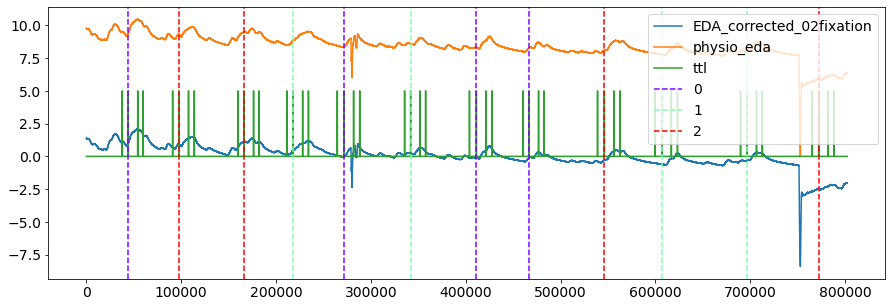

In [120]:
plot = nk.events_plot(event_stimuli, 
                      run_df[['EDA_corrected_02fixation','physio_eda','ttl']])

## 6.merge metadata with physio data

In [121]:
beh_df['cond_name'] = beh_df['param_cue_type'].astype(str) + '_' + beh_df['param_stimulus_type'].astype(str)

## 7.Process EDA signal @Isabel Neumann

note:

* all these steps are included in nk.eda_process and also in nk.bio_process
* with subdiving into low-level functions, we have more control over parameters like:
    * filters
    * minimum amplitude for SCRs (related to specific stimulus, not non-specific SCRs which appear in every eda signal but are not particularly related to a stimulus)


### processing steps include:

1. sanitize signal
  * returns a default indexed signal (really necessary?)
  
2. filter signal (comparable to nk.eda_clean)
  * returns array with filtered signal
  * smoothing or low-pass filtering (e.g., Butterworth filter) recommended to remove high-frequency noise and small artifacts
3. detrend the signals
4. decompose signal into phasic & tonic component
  * suggested by neurokit documentation -> helps to provide a more accurate estimation of the true SCR amplitude
  * signal is furthermore standardized which is also suggested by neurokit documentation -> useful in presence of high inter-individual variations, which usually is the case for pain perception
  * EDA_Tonic channel represents the skin conductance level (another measure of tonic skin conductance activity)
5. find peaks
  * returns dict with amplitude of SCR, samples at which SCR onset and SCR peaks occur (accessible with "SCR_Amplitude", "SCR_Onsets", "SCR_Peaks")
5. store signal

-- input from Isabel Neumann [isabel.neumann@dartmouth.edu](isabel.neumann@dartmouth.edu)

## # Skin Conductance Response (SCR) Phasic

### 7.1 EDA sanitize & 7.2 filter signals

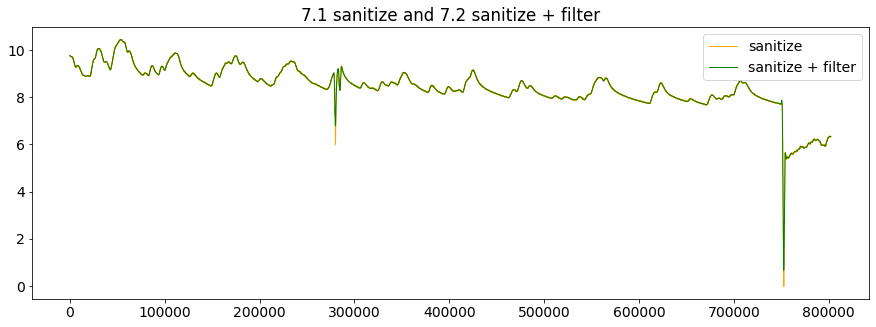

In [177]:

# IF you want to use raw signal
# eda_signal = nk.signal_sanitize(run_physio["Skin Conductance (EDA) - EDA100C-MRI"])
# eda_raw_plot = plt.plot(run_df["Skin Conductance (EDA) - EDA100C-MRI"])

amp_min = 0.01
scr_signal = nk.signal_sanitize(
    run_df['physio_eda'])
scr_filters = nk.signal_filter(scr_signal, 
                               sampling_rate=samplingrate, 
                               highcut=1, method="butterworth", order=2)
figure, ax1 = plt.subplots()
ax1.title.set_text('7.1 sanitize and 7.2 sanitize + filter')
l1 = ax1.plot(scr_signal, linewidth=1, zorder=1, label="sanitize", color="orange")
l2 = ax1.plot(scr_filters, linewidth=1, zorder=1, label="sanitize + filter", color="green")
ax1.legend(handles=[ l1[0], l2[0]])

### 7.3 detrend

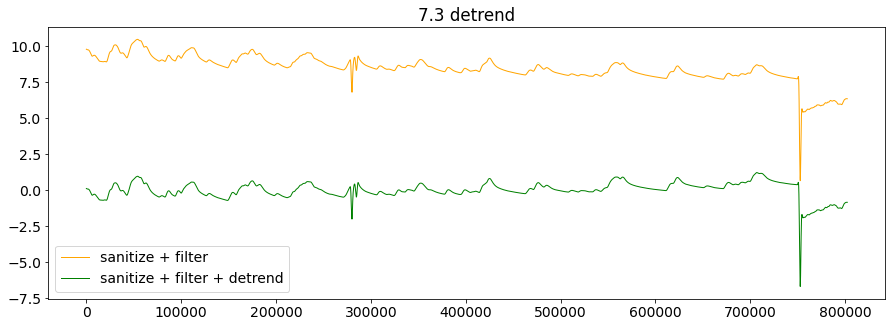

In [139]:
scr_detrend = nk.signal_detrend(scr_filters)
figure, ax1 = plt.subplots()
ax1.title.set_text('7.3 detrend')
# l1 = ax1.plot(run_df["EDA_corrected_02fixation"], linewidth=1.5, zorder=1, label="baseline corrected", color="gray")
l1 = ax1.plot(scr_filters, linewidth=1, zorder=1, label="sanitize + filter", color="orange")
l2 = ax1.plot(scr_detrend, linewidth=1, zorder=1, label="sanitize + filter + detrend", color="green")
ax1.legend(handles=[l1[0], l2[0]])

### 7.4 decompose EDA signal (tonic/phasic)

Text(0.5, 1.0, '7.4 decomposition of the eda signals: tonic & phasic')

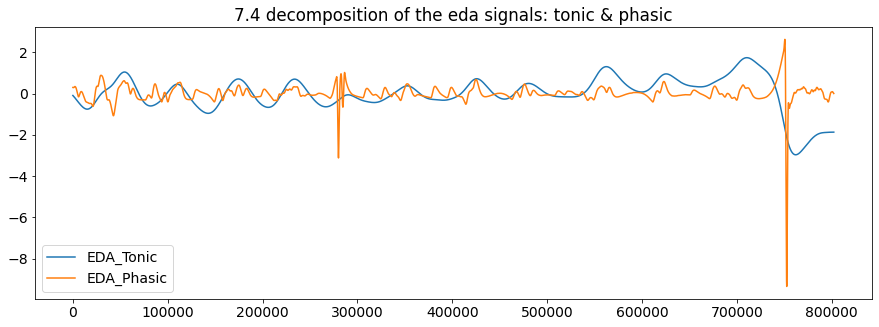

In [176]:

scr_decomposed = nk.eda_phasic(nk.standardize(scr_detrend), 
                               sampling_rate=samplingrate) 
scr_decomposed_plot = scr_decomposed.plot()

scr_peaks, info = nk.eda_peaks(scr_decomposed["EDA_Phasic"].values,
                               sampling_rate=samplingrate, 
                               method = "neurokit", amplitude_min = 0.02)  
scr_signals = pd.DataFrame({"EDA_Raw": scr_signal, "EDA_Clean": scr_signal})
scr_processed = pd.concat([scr_signals, scr_decomposed, scr_peaks], axis=1) 
# eda_level_signal = eda_processed["EDA_Tonic"] # for skin conductance level
plt.title("7.4 decomposition of the eda signals: tonic & phasic")

Text(0.5, 1.0, "Let's check the alignment of the condition types and the tonic/phasic signals")

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


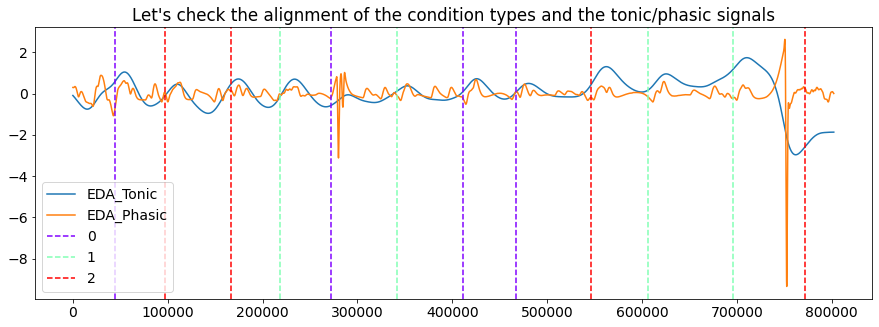

In [158]:
plot_eda_phasic = nk.events_plot(event_stimuli, 
                                 scr_processed[["EDA_Tonic", "EDA_Phasic"]])
plt.title("Let's check the alignment of the condition types and the tonic/phasic signals")


### 7.5 epochs_create
> Lastly, we need to create epochs based on the start of the stimulus and also designate the start and end of the event. 
* In this example, we time-lock it to the start of the pain plateau, i.e. the 2nd TTL, because we have precision of the pain heat stimulus. 
* Because we're dealing with phasic activity, we also limit the time span of this signal to the duration of the plateau, i.e. 5 seconds. 

In [168]:
scr_epochs = nk.epochs_create(scr_processed,
                              event_stimuli,
                              sampling_rate=samplingrate,
                              epochs_start=0,
                              epochs_end=5,
                              baseline_correction=True) 
scr_epochs[2] # produces a dictionary per trial (in this example, 12 keys, and 10000 rows, i.e. 5 seconds with 14 columns related to SCR data)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime,Index,Label,Condition
0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,high_stim
0.0005,0.001526,0.001526,0.000061,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,high_stim
0.0010,0.001526,0.001526,0.000122,0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,high_stim
0.0015,0.000000,0.000000,0.000183,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2,high_stim
0.0020,0.003052,0.003052,0.000245,0.000056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2,high_stim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.9980,0.234985,0.234985,0.258988,0.194699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9995.0,2,high_stim
4.9985,0.238037,0.238037,0.258973,0.194552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9996.0,2,high_stim
4.9990,0.236511,0.236511,0.258958,0.194405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9997.0,2,high_stim
4.9995,0.238037,0.238037,0.258944,0.194258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9998.0,2,high_stim


### 7.6 eda_eventrelated

* event-related analysis
* of interest especially when analyzing EDA responses to specific stimuli
* returns:
   * EDA_SCR: Skin Conductance Response yes (1) or no (0) -> if yes, corresponding components are listed
   * EDA_Peak_Amplitude: maximum amplitude of phasic component of signal
   * SCR_Peak_Amplitude: peak amplitude of the first SCR in each epoch (parameter of interest if related to specific stimulus)
   * SCR_Peak_Amplitude_Time: timpepoint of each first SCR peak amplitude (peak should occur within 2-7 s after stimulus onset)
   * SCR_RiseTime: risetime of each first SCR (time it takes for SCR to reach peak amplitude from onset)
   * SCR_RecoveryTime: half-recovery time of each first SCR (time it takes for SCR to decrease to half amplitude)

In [169]:
scr_phasic = nk.eda_eventrelated(scr_epochs)
scr_phasic # produces a dataframe with 12 trials and average information: EDA_Peak_Amplitude	EDA_SCR	SCR_Peak_Amplitude	SCR_Peak_Amplitude_Time	SCR_RiseTime	SCR_RecoveryTime

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,med_stim,0.0,1.438436,0,NaN,NaN,NaN,NaN
1,1,high_stim,0.0,0.314773,0,NaN,NaN,NaN,NaN
2,2,high_stim,0.0,0.286243,1,0.519559,4.353435,2.3455,3172.0
3,3,low_stim,0.0,0.220849,0,NaN,NaN,NaN,NaN
4,4,med_stim,0.0,1.031767,1,1.046368,3.224822,3.5260,7082.0
5,5,low_stim,0.0,0.566263,0,NaN,NaN,NaN,NaN
6,6,med_stim,0.0,0.437365,0,NaN,NaN,NaN,NaN
7,7,med_stim,0.0,0.379931,1,0.383933,0.423542,2.3590,3594.0
8,8,high_stim,0.0,0.528146,0,NaN,NaN,NaN,NaN
9,9,low_stim,0.0,0.307403,0,NaN,NaN,NaN,NaN


> We're done with the SCR Phasic signal extraction! 🥳
All we need to do is save this!

## Skin Conductance Level (SCL) Tonic

#### eda tonic
* interval-related analysis
* of interest for longer time periods, also resting-state (input could therefore also be a whole condition instead of snipped-out epochs)
* returns:
   * SCR_Peaks_N: number of occurrences of Skin Conductance Response
   * SCR_Peaks_Amplitude_Mean: mean amplitude of SCR peak occurrences

#### eda level
* analysis of skin conductance level

* For the tonic signals, note that we need baseline corrected signals. Other than that, we'll use very similar steps to SCR phasic: 
* signal ➔ filters ➔ detrend ➔ decompose.
* The difference is that we'll use the `tonic` signals from the decomposed stage, and feed them into a neurokit function `epochs_create`


In [153]:
tonic_epoch_start = -1
tonic_epoch_end = 8
tonic_length = np.abs(tonic_epoch_start-tonic_epoch_end) * samplingrate
scl_signal = nk.signal_sanitize(run_df['EDA_corrected_02fixation'])
scl_filters = nk.signal_filter(scl_signal,
                                sampling_rate=samplingrate,
                                highcut=1,
                                method="butterworth",
                                order=2)  # ISABEL: Detrend
scl_detrend = nk.signal_detrend(scl_filters)
scl_decomposed = nk.eda_phasic(nk.standardize(scl_detrend),
                                sampling_rate=samplingrate)
scl_signals = pd.DataFrame({
    "EDA_Raw": scl_signal,
    "EDA_Clean": scl_filters
})
scl_processed = pd.concat([scl_signals, scl_decomposed['EDA_Tonic']],
                          axis=1)

scl_epoch = nk.epochs_create(scl_processed['EDA_Tonic'],
                              event_stimuli,
                              sampling_rate=samplingrate,
                              epochs_start=tonic_epoch_start,
                              epochs_end=tonic_epoch_end,
                              baseline_correction=True)

Text(0.5, 1.0, 'plotting one trajectory of a SCL response')

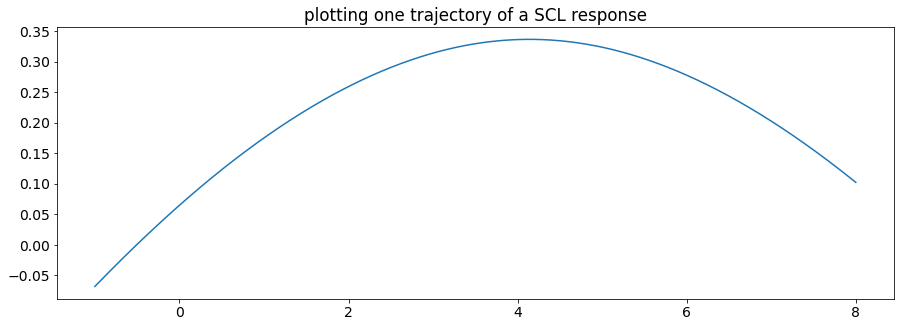

In [154]:
scl_epoch[2]["Signal"].plot()
plt.title("plotting one trajectory of a SCL response")

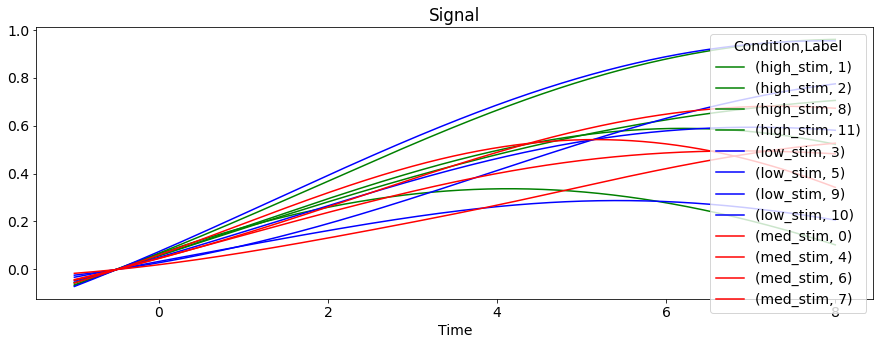

In [155]:
plot_level = nk.epochs_plot(scl_epoch)

In [160]:
scl_epoch[2]

,Signal,Index,Label,Condition
-1.0000,-0.068151,-999.5,2,high_stim
-0.9995,-0.068079,-998.5,2,high_stim
-0.9990,-0.068008,-997.5,2,high_stim
-0.9985,-0.067936,-996.5,2,high_stim
-0.9980,-0.067865,-995.5,2,high_stim
...,...,...,...,...
7.9980,0.102587,16995.5,2,high_stim
7.9985,0.102531,16996.5,2,high_stim
7.9990,0.102475,16997.5,2,high_stim
7.9995,0.102419,16998.5,2,high_stim


In [170]:
# loop over dictionary
# calculate mean signal 
# make sure to include the label and condition
# eda_tonic_decomposed_df 
# etd_df

eda_level = pd.DataFrame(index = list(range(len(scl_epoch))),
                         columns=['trial_order', 'iv_stim', 'mean_signal'])
for ind in range(len(scl_epoch)):
    eda_level.iloc[ind, eda_level.columns.get_loc('mean_signal')] = scl_epoch[ind]["Signal"].mean()
    eda_level.iloc[ind, eda_level.columns.get_loc('trial_order')] = scl_epoch[ind]['Label'].unique()[0]
    eda_level.iloc[ind, eda_level.columns.get_loc('iv_stim')] = scl_epoch[ind]["Condition"].unique()[0]

eda_level

,trial_order,iv_stim,mean_signal
0,0,med_stim,0.354719
1,1,high_stim,0.377869
2,2,high_stim,0.221331
3,3,low_stim,0.557226
4,4,med_stim,0.24337
5,5,low_stim,0.188192
6,6,med_stim,0.394731
7,7,med_stim,0.31285
8,8,high_stim,0.543853
9,9,low_stim,0.36405


We're also done extracting SCR tonic signals 🥳 Save this to a file :) 